# RQ 1: rivers

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

Relative importance of rivers for trace metal cycles; general component comparison (how important are the rivers for Mn)

In [6]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt

%matplotlib notebook

In [10]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load domain dimensions for reference:

In [12]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask = tmask[0,:,1480:2050,160:800]

In [21]:
ref   = nc.Dataset('/data/brogalla/run_storage/trial4/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
lons  = np.array(ref.variables['nav_lon'])[1480:2050,160:800]
lats  = np.array(ref.variables['nav_lat'])[1480:2050,160:800]
depth = np.array(ref.variables['deptht'])

In [22]:
# Load structure from sample dataset:
lat_model = ref.variables['nav_lat']
lon_model = ref.variables['nav_lon']
depths_model = ref.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

### Load Mn model run results:

In [23]:
def load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav):
    
    file   = 'ANHA12_EXH006_2015_monthly.nc'
    ref_monthly  = nc.Dataset(folder_ref+file)
    riv_monthly  = nc.Dataset(folder_riv+file)
    sed_monthly  = nc.Dataset(folder_sed+file)
#     bio_monthly  = nc.Dataset(folder_bio+file)
    atm_monthly  = nc.Dataset(folder_atm+file)
    ice_monthly  = nc.Dataset(folder_ice+file)
    scav_monthly = nc.Dataset(folder_scav+file)
    
    dmn_ref_monthly  = np.array(ref_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_riv_monthly  = np.array(riv_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_sed_monthly  = np.array(sed_monthly.variables['dissolmn'])[:,0,:,:,:]
#     dmn_bio_monthly  = np.array(bio_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_atm_monthly  = np.array(atm_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_ice_monthly  = np.array(ice_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_scav_monthly = np.array(scav_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    tmask_full    = np.empty(dmn_ref_monthly.shape)
    tmask_full[:] = tmask
    
    dmn_mref  = np.ma.masked_where((tmask_full < 0.1), dmn_ref_monthly)
    dmn_mriv  = np.ma.masked_where((tmask_full < 0.1), dmn_riv_monthly)
    dmn_msed  = np.ma.masked_where((tmask_full < 0.1), dmn_sed_monthly)
#     dmn_mbio  = np.ma.masked_where((tmask_full < 0.1), dmn_bio_monthly)
    dmn_matm  = np.ma.masked_where((tmask_full < 0.1), dmn_atm_monthly)
    dmn_mice  = np.ma.masked_where((tmask_full < 0.1), dmn_ice_monthly)
    dmn_mscav = np.ma.masked_where((tmask_full < 0.1), dmn_scav_monthly)

    return dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav

In [26]:
folder_ref  = '/data/brogalla/run_storage/trial4/ref-2015/'
folder_riv  = '/data/brogalla/run_storage/comp-riv-off-2015/'
folder_sed  = '/data/brogalla/run_storage/comp-sed-off-2015/'
folder_atm  = '/data/brogalla/run_storage/comp-atm-off-2015/'
folder_ice  = '/data/brogalla/run_storage/comp-ice-off-2015/'
folder_scav = '/data/brogalla/run_storage/comp-sca-off-2015/'

In [27]:
dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav = \
        load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav)

Calculate the proportional contribution of each component to each grid cell:

In [158]:
def calculate_prop(dmn_on, dmn_off):
    # Input arguments:
    # - dmn_on (t,z,y,x) --- concentration of dMn with component on
    # - dmn_off(t,z,y,x) --- concentration of dMn with component off
    
    # Contribution of component at each point
    diff = dmn_on - dmn_off    
    
    # Output:
    # - prop(t,z,y,x)  --- proportional contribution of component to simulated [dMn]
    return diff

In [159]:
def all_props(ref, riv, sed, atm, ice, scav):
    
    riv_prop  = calculate_prop(ref, riv)
    sed_prop  = calculate_prop(ref, sed)
#     bio_prop  = calculate_prop(ref, bio)
    atm_prop  = calculate_prop(ref, atm)
    ice_prop  = calculate_prop(ref, ice)
    scav_prop = calculate_prop(ref, scav)
    
    return riv_prop, sed_prop, atm_prop, ice_prop, scav_prop

In [160]:
riv_prop, sed_prop, atm_prop, ice_prop, scav_prop = \
    all_props(dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav)

In [161]:
width = 0.5

colors = ['#ccb598', '#007378', '#739f78', '#cc7722', '#cee7fd'] # dust, rivers, scavenging, sediment diffusion

months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

### Bar plots

In [144]:
riv_prop.shape

(12, 50, 570, 640)

In [145]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

Load volume of grid cells:

In [84]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [47]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

In [57]:
e1t    = np.tile(e1t_base, (50,1,1))
e2t    = np.tile(e2t_base, (50,1,1))

In [58]:
volume = e1t*e2t*e3t

In [162]:
atm = atm_prop*volume
riv = riv_prop*volume
sca = scav_prop*volume
sed = sed_prop*volume
ice = ice_prop*volume

Subdivide into layers:

In [170]:
total = np.sum(atm + riv + np.abs(sca) + sed + ice, axis=(1,2,3))

In [171]:
def layers(bottom, top):
    
#     dust_ave   = np.average(atm[:,bottom:top,:,:], axis=(1,2,3))
#     rivers_ave = np.average(riv[:,bottom:top,:,:], axis=(1,2,3))
#     scav_ave   = np.average(sca[:,bottom:top,:,:], axis=(1,2,3))
#     sed_ave    = np.average(sed[:,bottom:top,:,:], axis=(1,2,3))
#     ice_ave    = np.average(ice[:,bottom:top,:,:], axis=(1,2,3))

    dust_ave   = np.sum(atm[:,bottom:top,:,:], axis=(1,2,3))
    rivers_ave = np.sum(riv[:,bottom:top,:,:], axis=(1,2,3))
    scav_ave   = np.sum(sca[:,bottom:top,:,:], axis=(1,2,3))
    sed_ave    = np.sum(sed[:,bottom:top,:,:], axis=(1,2,3))
    ice_ave    = np.sum(ice[:,bottom:top,:,:], axis=(1,2,3))

    dust_sum_ave   = dust_ave*100/total
    rivers_sum_ave = rivers_ave*100/total
    scav_sum_ave   = scav_ave*100/total
    sed_sum_ave    = sed_ave*100/total
    ice_sum_ave    = ice_ave*100/total
    
    return dust_sum_ave, rivers_sum_ave, scav_sum_ave, sed_sum_ave, ice_sum_ave

In [172]:
def plot_layer(dust_layer, riv_layer, scav_layer, sed_layer, ice_layer):
    
    fig, ax = plt.subplots(figsize=(6,4))

    for i in range(0,12):
        ax.bar(months[i], scav_layer[i], width, color=colors[2])
        ax.bar(months[i], dust_layer[i], width, color=colors[0])
        ax.bar(months[i], riv_layer[i], width, bottom=dust_layer[i], color=colors[1])
        ax.bar(months[i], sed_layer[i], width, bottom=np.add(dust_layer[i], riv_layer[i]), color=colors[3])
        ax.bar(months[i], ice_layer[i], width, bottom=np.add(np.add(dust_layer[i], riv_layer[i]), sed_layer[i]), color=colors[4])

    # for legend:
    ax.bar(months[0], dust_layer[0]  , 0, color=colors[0], label='Dust')
    ax.bar(months[0], riv_layer[0], 0, color=colors[1], label='Rivers')
    ax.bar(months[0], scav_layer[0]  , 0, color=colors[2], label='Scavenging')
    ax.bar(months[0], sed_layer[0]   , 0, color=colors[3], label='Sediment resuspension')
    ax.bar(months[0], ice_layer[0]   , 0, color=colors[4], label='Ice')
    ax.legend(loc=(1.05,0.05), frameon=False)

    # xmin, xmax = ax.get_xlim()
    # ax.set_xlim([xmin, xmax])
    # ax.plot([xmin, xmax],[0, 0],'-k',linewidth=1)
    # ax.ticklabel_format(axis='y',scilimits=(-1, 1))
    ax.set_ylabel('Average contribution to total dMn [%]')
    
    return

<IPython.core.display.Javascript object>


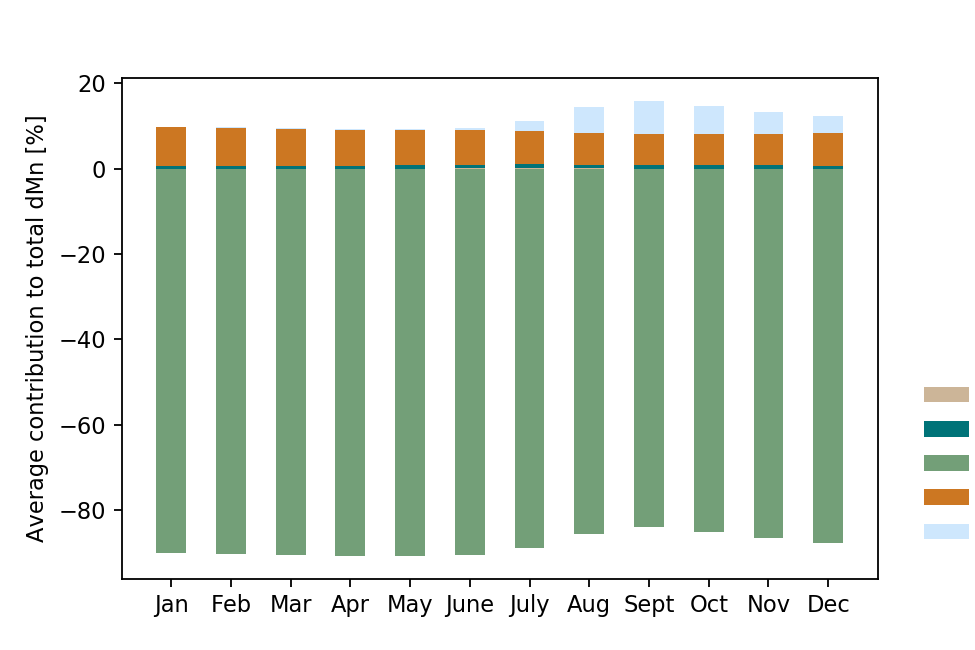

In [173]:
dust_all, riv_all, scav_all, sed_all, ice_all = layers(0,50)
plot_layer(dust_all, riv_all, scav_all, sed_all, ice_all)

<IPython.core.display.Javascript object>


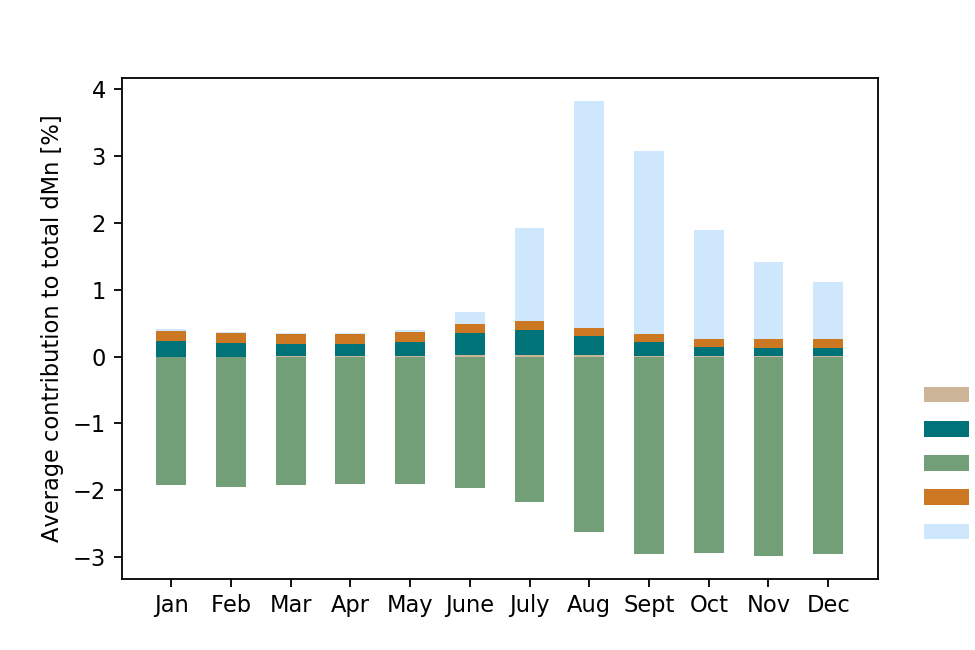

In [174]:
dust_surf, riv_surf, scav_surf, sed_surf, ice_surf = layers(0,5)
plot_layer(dust_surf, riv_surf, scav_surf, sed_surf, ice_surf)

<IPython.core.display.Javascript object>


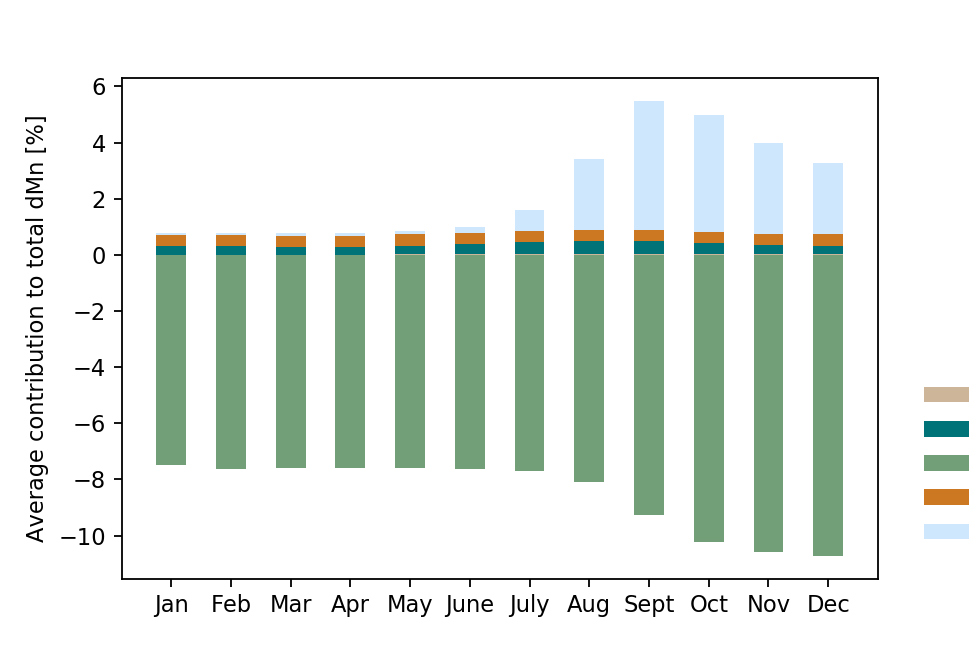

In [175]:
dust_subsurf, riv_subsurf, scav_subsurf, sed_subsurf, ice_subsurf = layers(5,15)
plot_layer(dust_subsurf, riv_subsurf, scav_subsurf, sed_subsurf, ice_subsurf)

<IPython.core.display.Javascript object>


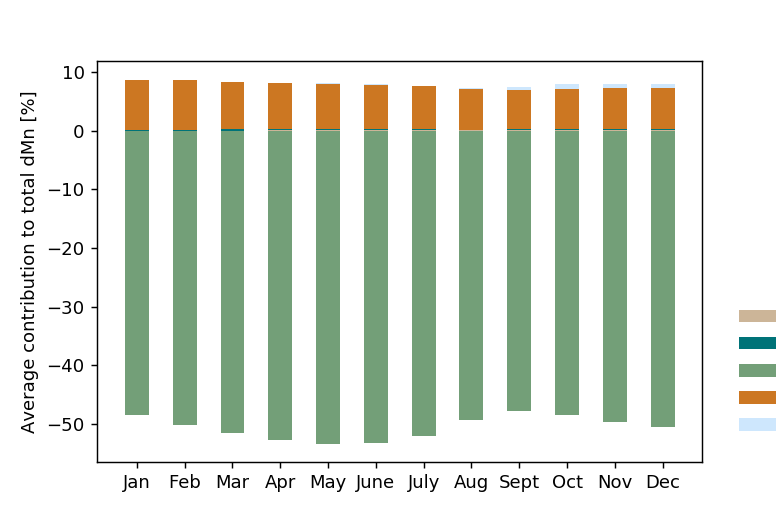

In [176]:
dust_deep, riv_deep, scav_deep, sed_deep, ice_deep = layers(15,35)
plot_layer(dust_deep, riv_deep, scav_deep, sed_deep, ice_deep)

### Overview of component contributions within water masses: 

- Polar mixed layer (0-40 m)
    - PML depth levels = 1 to 17
- Pacific/halocline water (40-300 m)
    - PW depth levels = 17 to 29
- Atlantic water (300-800 m)
    - AW depth levels = 29 to 35
- Deep water (> 800 m)
    - DW depth levels = 35-50
    
Note that if a component has a negative contribution (i.e. removal), I take the absolute value of this contribution. So, what I'm really looking at is the importance of the component in the concentration/distribution of the trace metal.

<IPython.core.display.Javascript object>


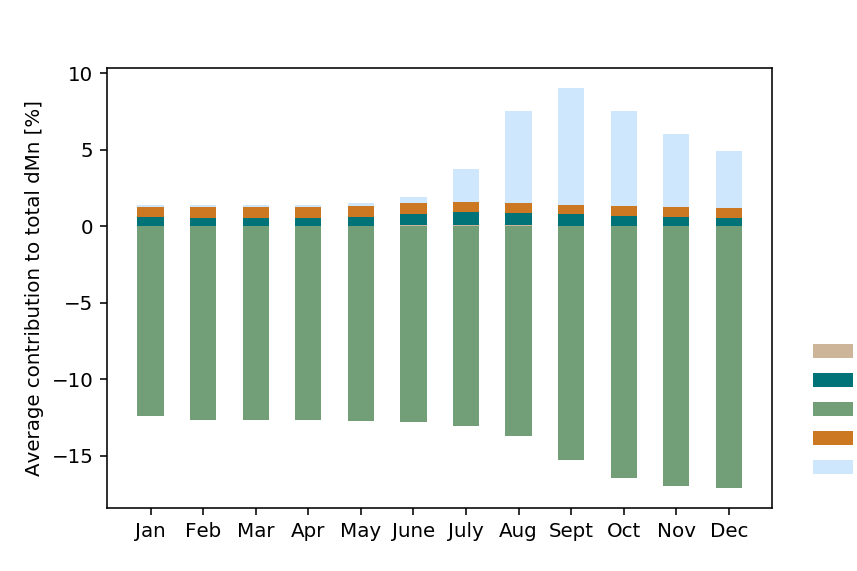

In [177]:
dust_PML, riv_PML, scav_PML, sed_PML, ice_PML = layers(0,17)
plot_layer(dust_PML, riv_PML, scav_PML, sed_PML, ice_PML)
# PML_total = PML_dust_ave + PML_rivers_ave + PML_scav_ave + PML_sed_ave + PML_ice_ave

<IPython.core.display.Javascript object>


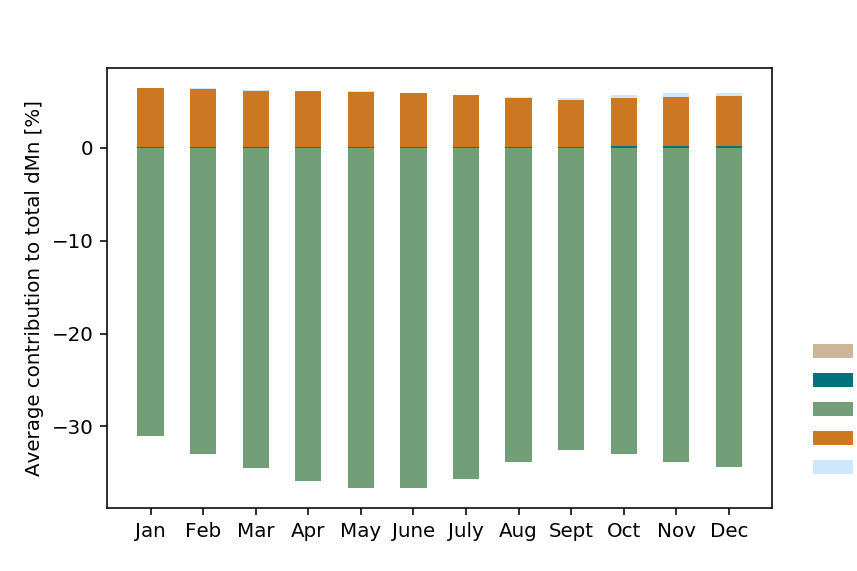

In [178]:
dust_PW, riv_PW, scav_PW, sed_PW, ice_PW = layers(17,29)
plot_layer(dust_PW, riv_PW, scav_PW, sed_PW, ice_PW)
# PW_total = PW_dust_ave + PW_rivers_ave + PW_scav_ave + PW_sed_ave + PW_ice_ave

<IPython.core.display.Javascript object>


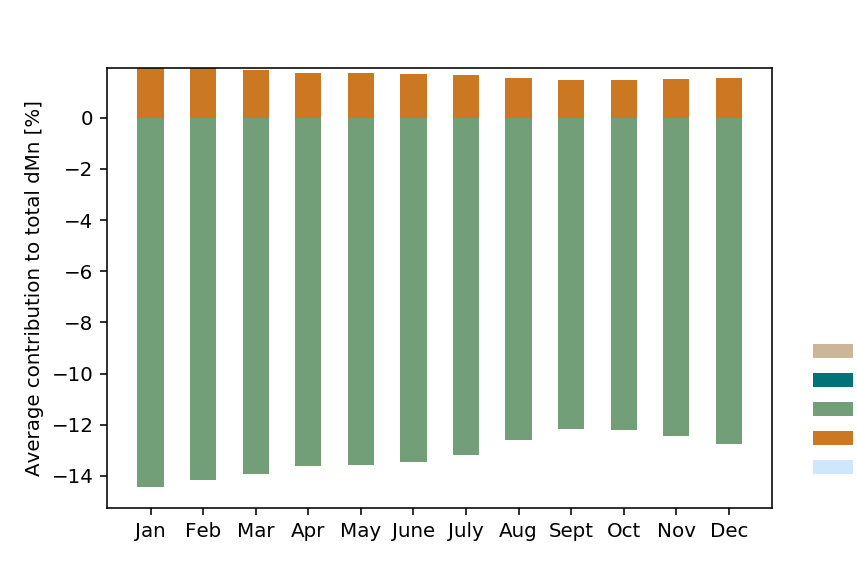

In [179]:
dust_AW, riv_AW, scav_AW, sed_AW, ice_AW = layers(29,35)
plot_layer(dust_AW, riv_AW, scav_AW, sed_AW, ice_AW)
# AW_total = AW_dust_ave + AW_rivers_ave + AW_scav_ave + AW_sed_ave + AW_ice_ave

<IPython.core.display.Javascript object>


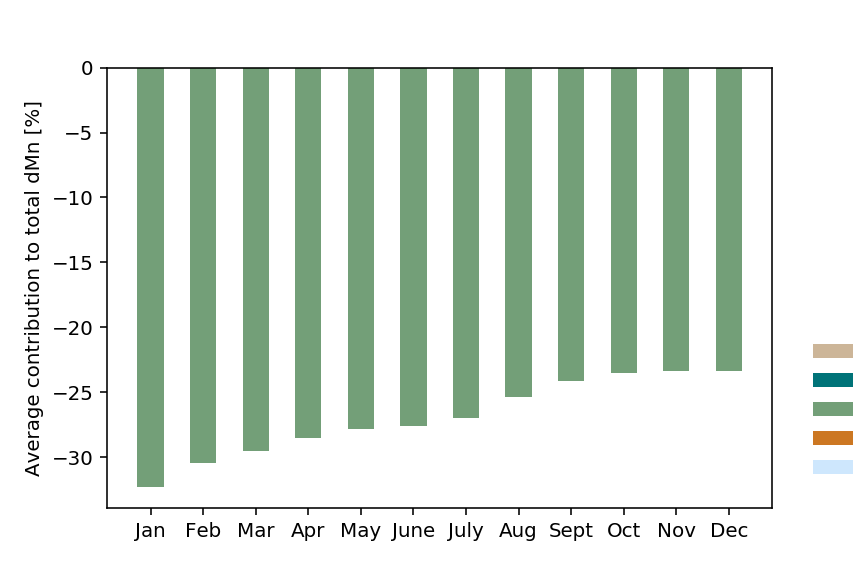

In [180]:
dust_DW, riv_DW, scav_DW, sed_DW, ice_DW = layers(35,50)
plot_layer(dust_DW, riv_DW, scav_DW, sed_DW, ice_DW)
# DW_total = DW_dust_ave + DW_rivers_ave + DW_scav_ave + DW_sed_ave + DW_ice_ave

In [ ]:
def proportions_bar(fig, ax, ice_sum_ave, dust_sum_ave, rivers_sum_ave, scav_sum_ave, sed_sum_ave, name, legend=False):
    for i in range(0,12):
        ax.bar(months[i], dust_sum_ave[i], width, color=colors[0])
        ax.bar(months[i], rivers_sum_ave[i], width, bottom=dust_sum_ave[i], color=colors[1])
        ax.bar(months[i], scav_sum_ave[i], width, bottom=np.add(dust_sum_ave[i],rivers_sum_ave[i]), color=colors[2])
        ax.bar(months[i], sed_sum_ave[i], width, bottom=np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]),scav_sum_ave[i]), color=colors[3])
        ax.bar(months[i], ice_sum_ave[i], width, bottom=np.add(np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]), \
                                                               scav_sum_ave[i]),sed_sum_ave[i]), color=colors[4])

    ax.set_title(name, fontsize=14)
    # for legend:
    if legend:
        ax.bar(months[0], dust_sum_ave[0]  , 0, color=colors[0], label='Dust')
        ax.bar(months[0], rivers_sum_ave[0], 0, color=colors[1], label='Rivers')
        ax.bar(months[0], scav_sum_ave[0]  , 0, color=colors[2], label='Scavenging')
        ax.bar(months[0], sed_sum_ave[0]   , 0, color=colors[3], label='Sediment resuspension')
        ax.bar(months[0], ice_sum_ave[0]   , 0, color=colors[4], label='Ice')
        ax.legend(loc=(1.05, 0.05), frameon=False)
    return

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

proportions_bar(fig, ax[0,0], PML_ice_sum_ave, PML_dust_sum_ave, PML_rivers_sum_ave, \
                PML_scav_sum_ave, PML_sed_sum_ave, 'Polar mixed layer')
proportions_bar(fig, ax[0,1], PW_ice_sum_ave, PW_dust_sum_ave, PW_rivers_sum_ave, \
                PW_scav_sum_ave, PW_sed_sum_ave, 'Pacific/halocline layer')
proportions_bar(fig, ax[1,0], AW_ice_sum_ave, AW_dust_sum_ave, AW_rivers_sum_ave, \
                AW_scav_sum_ave, AW_sed_sum_ave, 'Atlantic layer')
proportions_bar(fig, ax[1,1], DW_ice_sum_ave, DW_dust_sum_ave, DW_rivers_sum_ave, \
                DW_scav_sum_ave, DW_sed_sum_ave, 'Deep layer', legend=True)

fig.text(0.06, 0.5, 'Average contribution to dMn [%]', \
         ha='center', va='center', rotation='vertical', fontsize=14);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn-components-layers-scavenging-20190917.png', bbox_inches='tight')

#### No removal:

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

proportions_bar(fig, ax[0,0], PML_ice_sum_ave, PML_dust_sum_ave, PML_rivers_sum_ave, \
                PML_scav_sum_ave, PML_sed_sum_ave, 'Polar mixed layer')
proportions_bar(fig, ax[0,1], PW_ice_sum_ave, PW_dust_sum_ave, PW_rivers_sum_ave, \
                PW_scav_sum_ave, PW_sed_sum_ave, 'Pacific/halocline layer')
proportions_bar(fig, ax[1,0], AW_ice_sum_ave, AW_dust_sum_ave, AW_rivers_sum_ave, \
                AW_scav_sum_ave, AW_sed_sum_ave, 'Atlantic layer')
proportions_bar(fig, ax[1,1], DW_ice_sum_ave, DW_dust_sum_ave, DW_rivers_sum_ave, \
                DW_scav_sum_ave, DW_sed_sum_ave, 'Deep layer', legend=True)

fig.text(0.06, 0.5, 'Average contribution to dMn [%]', \
         ha='center', va='center', rotation='vertical', fontsize=14);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn-components-layers-20190917.png', bbox_inches='tight')

## Map of surface with the most important component

In [ ]:
def comp_importance(month, zlevel, riv_prop=riv_prop, sed_prop=sed_prop, atm_prop=atm_prop, ice_prop=ice_prop, \
                   scav_prop=scav_prop, output=False):
    
    riv_imp = np.ma.masked_where((riv_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                             riv_prop[month,z_level,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < atm_prop[month,z_level,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < ice_prop[month,z_level,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < scav_prop[month,z_level,:,:]), riv_imp[:,:])

    sed_imp = np.ma.masked_where((sed_prop[month,z_level,:,:] < riv_prop[month,z_level,:,:]), \
                                 sed_prop[month,z_level,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < atm_prop[month,z_level,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < ice_prop[month,z_level,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < scav_prop[month,z_level,:,:]), sed_imp[:,:])


    sca_imp = np.ma.masked_where((scav_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 scav_prop[month,z_level,:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < atm_prop[month,z_level,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < ice_prop[month,z_level,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < riv_prop[month,z_level,:,:]), sca_imp[:,:])

    ice_imp = np.ma.masked_where((ice_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 ice_prop[month,z_level,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,z_level,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,z_level,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < scav_prop[month,z_level,:,:]), ice_imp[:,:])

    atm_imp = np.ma.masked_where((atm_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 atm_prop[month,z_level,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,z_level,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,z_level,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < scav_prop[month,z_level,:,:]), atm_imp[:,:])

    if output:
        print('Rivers     --- Masked values before: ', np.ma.count_masked(riv_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers     --- Non-masked values:    ',np.ma.count(riv_imp[:,:]))
        print('Sediment   --- Masked values before: ', np.ma.count_masked(sed_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment   --- Non-masked values:    ',np.ma.count(sed_imp[:,:]))
        print('Scavenging --- Masked values before: ', np.ma.count_masked(scav_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(sca_imp[:,:]))
        print('Scavenging --- Non-masked values:    ',np.ma.count(sca_imp[:,:]))
        print('Ice        --- Masked values before: ', np.ma.count_masked(ice_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Ice        --- Non-masked values:    ',np.ma.count(ice_imp[:,:]))
        print('Dust       --- Masked values before: ', np.ma.count_masked(atm_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust       --- Non-masked values:    ',np.ma.count(atm_imp[:,:]))

    return riv_imp, sed_imp, sca_imp, ice_imp, atm_imp

In [ ]:
month   = 8
z_level = 0

In [ ]:
riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month, z_level, output=True)

### If we only count the sources of dMn (so no removal by scavenging):

In [ ]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------
x, y = proj1(lon_model, lat_model)
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=0.1,c=colors[0])
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=0.1, c=colors[1])
proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=0.1, c=colors[2])
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=0.1, c=colors[3])
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=0.1, c=colors[4])

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax1.legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_only-sources.png', bbox_inches='tight')

### Seasonal cycle:

In [ ]:
def plot_year_importance(z_level, fig, ax, proj1):
    
    x, y = proj1(lon_model, lat_model)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month, z_level)
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=0.1,c=colors[0], ax=axes[month])
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=0.1, c=colors[1], ax=axes[month])
        proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=0.1, c=colors[2], ax=axes[month])
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=0.1, c=colors[3], ax=axes[month])
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=0.1, c=colors[4], ax=axes[month])
        axes[month].set_title(months[month])
    
    return

In [ ]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(z_level, fig, ax, proj1)

proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_seasonal-20190917.png', bbox_inches='tight')

In [ ]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

z_level=30
plot_year_importance(z_level, fig, ax, proj1)

proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_seasonal-20190917.png', bbox_inches='tight')

### If we look at the total impact (i.e. including scavenging removal):

In [ ]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------
x, y = proj1(lon_model, lat_model)
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=0.2,c=colors[0])
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=0.2, c=colors[1])
proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=0.2, c=colors[2])
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=0.2, c=colors[3])
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=0.2, c=colors[4])

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax1.legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_sources-and-removal.png', bbox_inches='tight')

In [ ]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(z_level, fig, ax, proj1)

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_seasonal-scavenging-20190917.png', bbox_inches='tight')

# Same thing but summed over the different water depth layers: